# Credit Card Risk Assessment Using Ensemble Learning Models

### Import Required Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Import specific classes and functions from scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Import set_config from scikit-learn to configure display options
from sklearn import set_config

# Ignore warnings to ensure clean output
import warnings
warnings.filterwarnings('ignore')

# Set the display configuration for scikit-learn
set_config(display='diagram')

### Load the Dataset

In [2]:
credit_risk = pd.read_csv('Datasets/credit_risk_dataset.csv')
credit_risk

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [3]:
credit_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [4]:
credit_risk.shape

(32581, 12)

The problem consists of predicting a label for each loan/person. The target column, 'loan_status,' provides a binary classification for the loan status (0 if not in default, 1 if in default). The 11 features can be split into seven numerical and four categorical features, which must be processed separately. Below, we can explore the statistics of the numerical features plus the target.

In [5]:
credit_risk.describe().round(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.00,32581.00,31686.00,32581.00,29465.00,32581.00,32581.00,32581.00
mean,27.73,66074.85,4.79,9589.37,11.01,0.22,0.17,5.80
std,6.35,61983.12,4.14,6322.09,3.24,0.41,0.11,4.06
min,20.00,4000.00,0.00,500.00,5.42,0.00,0.00,2.00
25%,23.00,38500.00,2.00,5000.00,7.90,0.00,0.09,3.00
50%,26.00,55000.00,4.00,8000.00,10.99,0.00,0.15,4.00
75%,30.00,79200.00,7.00,12200.00,13.47,0.00,0.23,8.00
max,144.00,6000000.00,123.00,35000.00,23.22,1.00,0.83,30.00


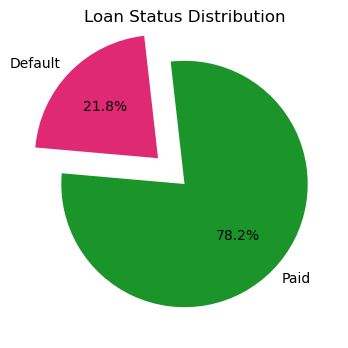

In [6]:
plt.figure(figsize=(10, 4))

# Define custom colors for non-default and default
non_default_color = '#1B952A'
default_color = '#DF2973'

# Custom colors for pie chart
custom_palette = [non_default_color, default_color]

loan_status_counts = credit_risk['loan_status'].value_counts()

labels = ['Paid', 'Default']
sizes = loan_status_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', explode=[0, 0.3], startangle=175, colors=custom_palette)
plt.title('Loan Status Distribution')
plt.show()

An initial observation is that the dataset requires class balance. The target population is divided, with 78.2% in class 0 (non-default) and 21.8% in class 1 (default).

#### 2. Data Scalling Pipelines

We separated features and target variables and created pipelines for each feature type. For ordinal categorical features, we used an ordinal encoder and MinMaxScaler; for nominal categorical features, a One Hot Encoder, and for numerical features, a simpler imputer and robust scaler. We combined these pipelines with ColumnTransformer() and split the dataset into train and test sets, ensuring balanced subsets with equal target class ratios.

In [38]:
### Extract Features

features = credit_risk.drop('loan_status', axis=1).reset_index(drop=True) 

### Extract Target
target = credit_risk['loan_status'].reset_index(drop=True) 

In [39]:
### Pipeline definition
categorical_Ordinal = Pipeline( steps = [("oe",
                                         OrdinalEncoder()),
                                        ("mmscale", MinMaxScaler())])

categorical_Nominal = Pipeline( steps = [("ohe", OneHotEncoder())])

numerical_Pipeline  = Pipeline( steps = [("impute",
                                          SimpleImputer(strategy="mean"))
                                         ,("scale", RobustScaler())])

In [41]:
### Select ordinal columns

ordinal_Column = ['loan_grade']

### Select categorical columns
categorical_Columns = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'] 

### Select numerical columns
numerical_Columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income'] 


### Make ColumnTransformer
column_transformation = ColumnTransformer(transformers=[("numerical", numerical_Pipeline, numerical_Columns),
                                    ("categorical", categorical_Nominal, categorical_Columns),
                                    ("ordinal", categorical_Ordinal, ordinal_Column)])

column_transformation

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scale', RobustScaler())]),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income']),
                                ('categorical',
                                 Pipeline(steps=[('ohe', OneHotEncoder())]),
                                 ['person_home_ownership', 'loan_intent',
                                  'cb_person_default_on_file']),
                                ('ordinal',
                                 Pipeline(steps=[('oe', OrdinalEncoder()),
                                                 ('mmscale', MinMaxScaler())]),
                                 ['loan_grade'])])